In [27]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
np.random.seed(42)

In [28]:
# Reading into the train and test directories

train_imgs = os.listdir('./train/')
test_imgs = os.listdir('./test/')

In [29]:
# Converting to dataframes
train_df = pd.DataFrame(train_imgs, columns= ['filename'])
test_df = pd.DataFrame(test_imgs, columns= ['filename'])

In [30]:
# Labeling each class based on the filename

train_df['class'] = train_df['filename'].map(lambda x: 'building' if x.startswith('building') else ('forest' if x.startswith('forest') else ('glacier' if x.startswith('glacier') else ('mountain' if x.startswith('mountain') else ('sea' if x.startswith('sea') else 'street')))))
test_df['class'] = test_df['filename'].map(lambda x: 'building' if x.startswith('building') else ('forest' if x.startswith('forest') else ('glacier' if x.startswith('glacier') else ('mountain' if x.startswith('mountain') else ('sea' if x.startswith('sea') else 'street')))))

In [31]:
train_df['label'] = train_df['class'].map(lambda x: 1 if x.startswith('build') else (2 if x.startswith('for') else (3 if x.startswith('glac') else (4 if x.startswith('mount') else (5 if x.startswith('sea') else 6)))))
test_df['label'] = test_df['class'].map(lambda x: 1 if x.startswith('build') else (2 if x.startswith('for') else (3 if x.startswith('glac') else (4 if x.startswith('mount') else (5 if x.startswith('sea') else 6)))))

In [32]:
# Checking out the dfs to ensure that the lambda function mapped correctly

train_df

,filename,class,label
0,sea_12479.jpg,sea,5
1,forest_9842.jpg,forest,2
2,sea_3497.jpg,sea,5
3,building_17805.jpg,building,1
4,glacier_14964.jpg,glacier,3
...,...,...,...
14029,building_18291.jpg,building,1
14030,building_909.jpg,building,1
14031,glacier_18821.jpg,glacier,3
14032,glacier_3295.jpg,glacier,3


In [33]:
test_df

,filename,class,label
0,glacier_23676.jpg,glacier,3
1,mountain_23428.jpg,mountain,4
2,forest_22748.jpg,forest,2
3,building_24203.jpg,building,1
4,forest_20605.jpg,forest,2
...,...,...,...
2995,glacier_20372.jpg,glacier,3
2996,mountain_23343.jpg,mountain,4
2997,glacier_20414.jpg,glacier,3
2998,mountain_21226.jpg,mountain,4


In [34]:
# Testing baselines for train set
train_df['class'].value_counts(normalize=True)

mountain    0.178994
glacier     0.171298
street      0.169731
sea         0.162035
forest      0.161821
building    0.156121
Name: class, dtype: float64

In [35]:
# Testing baselines for test set
test_df['class'].value_counts(normalize=True)

glacier     0.184333
mountain    0.175000
sea         0.170000
street      0.167000
forest      0.158000
building    0.145667
Name: class, dtype: float64

In [36]:
# Image data generator for train and test sets

train_data_gen = ImageDataGenerator(
    rescale = 1./255.,
    shear_range = 15,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

In [37]:
# Applying to the dataframes

train_data = train_data_gen.flow_from_dataframe(
    dataframe = train_df,
    directory = './train/',
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150), 
    batch_size = 64,
    class_mode = 'categorical'
)

test_data = test_data_gen.flow_from_dataframe(
    dataframe = test_df,
    directory = './test/',
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150), 
    batch_size = 64,
    class_mode = 'categorical'
)

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [39]:
# Setting up the first model
cnn_model_1 = Sequential()

cnn_model_1.add(Conv2D( 
  filters = 6, 
  kernel_size = (3, 3), 
  activation = 'relu', 
  input_shape = (150, 150, 3) 
))

cnn_model_1.add(MaxPooling2D(pool_size = (1, 1))) 

cnn_model_1.add(Conv2D(filters = 12,
                     kernel_size = (3, 3),
                     activation = 'relu'))

cnn_model_1.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model_1.add(Flatten())

cnn_model_1.add(Dense(units = 128, activation = 'relu'))
cnn_model_1.add(Dense(64, activation = 'relu'))
cnn_model_1.add(Dense(32, activation = 'relu'))
cnn_model_1.add(Dense(units = 6, activation = 'softmax'))

cnn_model_1.compile(loss = 'categorical_crossentropy',
                  optimizer ='adam',
                  metrics = ['accuracy'])

2022-10-28 12:13:03.511526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
# Fitting on 5 epochs with no specified batch size to start

cnn_model_1.fit(train_data,
                    validation_data=test_data,
                    epochs=5,
                    verbose=1)

Epoch 1/5
220/220 [==============================] - 162s 734ms/step - loss: 0.9160 - accuracy: 0.6532 - val_loss: 0.9156 - val_accuracy: 0.6550
Epoch 2/5
220/220 [==============================] - 165s 750ms/step - loss: 0.8011 - accuracy: 0.7050 - val_loss: 0.7693 - val_accuracy: 0.7203
Epoch 3/5
220/220 [==============================] - 165s 751ms/step - loss: 0.7339 - accuracy: 0.7332 - val_loss: 0.7150 - val_accuracy: 0.7500
Epoch 4/5
220/220 [==============================] - 173s 786ms/step - loss: 0.6987 - accuracy: 0.7428 - val_loss: 0.8499 - val_accuracy: 0.7290
Epoch 5/5
220/220 [==============================] - 167s 760ms/step - loss: 0.6631 - accuracy: 0.7612 - val_loss: 0.6750 - val_accuracy: 0.7643


Pretty solid accuracy on first trial and not overfit! Adding more epochs and a batch size now.

In [42]:
history = cnn_model_1.fit(train_data,
                    batch_size=128, # batch size 128 produced the best val accuracy
                    validation_data=test_data,
                    epochs=10,
                    verbose=1)

Epoch 1/10
220/220 [==============================] - 168s 762ms/step - loss: 0.6307 - accuracy: 0.7685 - val_loss: 0.7853 - val_accuracy: 0.7393
Epoch 2/10
220/220 [==============================] - 169s 767ms/step - loss: 0.6074 - accuracy: 0.7813 - val_loss: 0.7300 - val_accuracy: 0.7573
Epoch 3/10
220/220 [==============================] - 182s 827ms/step - loss: 0.5838 - accuracy: 0.7885 - val_loss: 0.6538 - val_accuracy: 0.7713
Epoch 4/10
220/220 [==============================] - 175s 792ms/step - loss: 0.5659 - accuracy: 0.7957 - val_loss: 0.6498 - val_accuracy: 0.7743
Epoch 5/10
220/220 [==============================] - 179s 813ms/step - loss: 0.5371 - accuracy: 0.8074 - val_loss: 0.6459 - val_accuracy: 0.7843
Epoch 6/10
220/220 [==============================] - 173s 783ms/step - loss: 0.5267 - accuracy: 0.8083 - val_loss: 0.6254 - val_accuracy: 0.7857
Epoch 7/10
220/220 [==============================] - 174s 790ms/step - loss: 0.5169 - accuracy: 0.8141 - val_loss: 0.5732 -

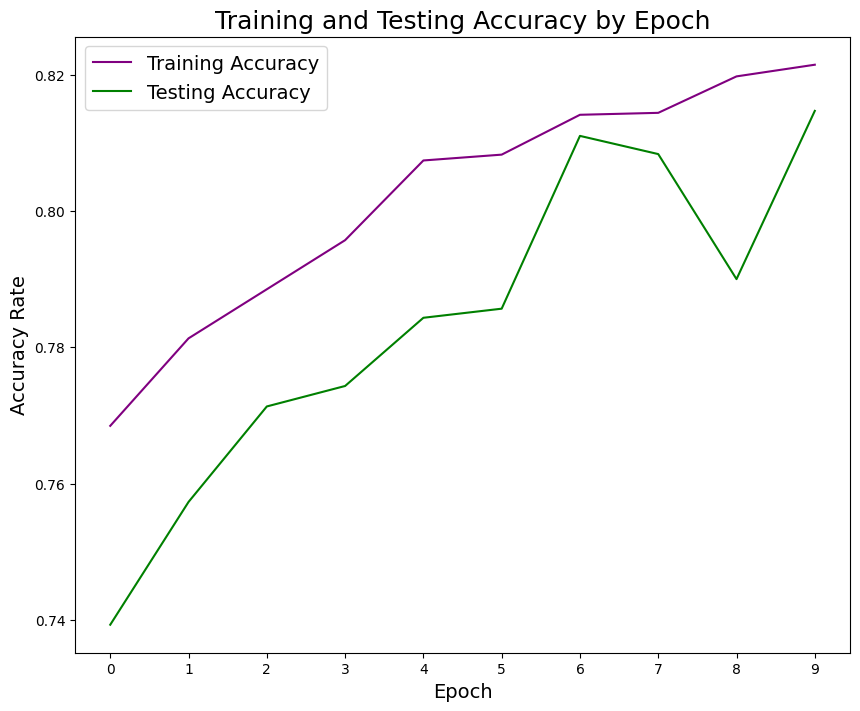

In [45]:
# Plotting train and test accuracy over epochs
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(10, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='purple')
plt.plot(test_loss, label='Testing Accuracy', color='green')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy Rate', fontsize=14)
plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 14);

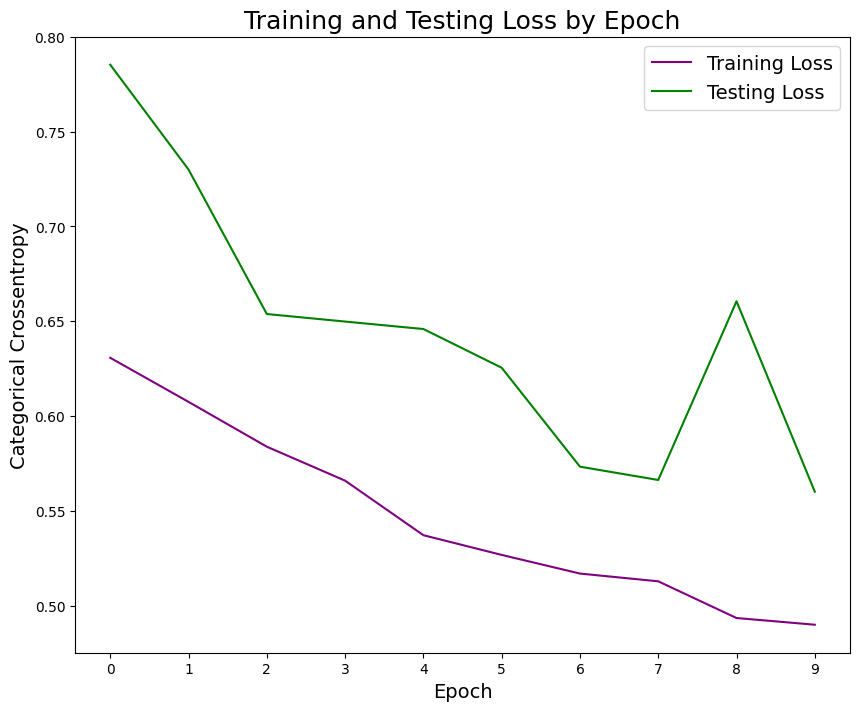

In [46]:
# Plotting train and test loss over epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(10, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='purple')
plt.plot(test_loss, label='Testing Loss', color='green')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Categorical Crossentropy', fontsize=14)
plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 14);

We can see in both of the above plots that the test set struggled in the ninth epoch. Otherwise, it looks like the model was able to bring the overfitting down over time, as well as reduce the loss for both the training and testing sets.

In all, it looks like the accuracy rate improvement slowed down in epochs 6 and 7, as this is where we see the lines flatten out a bit in the first plot. We see something similar in the second plot (crossentropy) as the rate of categorical crossentropy reduction slows down. I'm going to add in early stopping as a callback (and keep all else the same) to see if the model chooses to stop early or run through all ten epochs again.

In [47]:
# Setting up the early stopping model

es = EarlyStopping(
  monitor= 'val_accuracy', 
  patience=2, 
  min_delta=0.05,
  verbose = 1)

cnn_model_2 = Sequential()

cnn_model_2.add(Conv2D( 
  filters = 6, 
  kernel_size = (3, 3), 
  activation = 'relu', 
  input_shape = (150, 150, 3) 
))

cnn_model_2.add(MaxPooling2D(pool_size = (1, 1))) 

cnn_model_2.add(Conv2D(filters = 12,
                     kernel_size = (3, 3),
                     activation = 'relu'))

cnn_model_2.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model_2.add(Flatten())

cnn_model_2.add(Dense(units = 128, activation = 'relu'))
cnn_model_2.add(Dense(64, activation = 'relu'))
cnn_model_2.add(Dense(32, activation = 'relu'))
cnn_model_2.add(Dense(units = 6, activation = 'softmax'))

cnn_model_2.compile(loss = 'categorical_crossentropy',
                  optimizer ='adam',
                  metrics = ['accuracy'])

In [48]:
history_2 = cnn_model_2.fit(train_data,
                    batch_size=128, 
                    validation_data=test_data,
                    epochs=10,
                    verbose=1,
                    callbacks=[es])

Epoch 1/10
220/220 [==============================] - 171s 772ms/step - loss: 1.1198 - accuracy: 0.5698 - val_loss: 1.1514 - val_accuracy: 0.6073
Epoch 2/10
220/220 [==============================] - 149s 677ms/step - loss: 0.8433 - accuracy: 0.6836 - val_loss: 0.8869 - val_accuracy: 0.6910
Epoch 3/10
220/220 [==============================] - 147s 667ms/step - loss: 0.7600 - accuracy: 0.7182 - val_loss: 0.8736 - val_accuracy: 0.7113
Epoch 4/10
220/220 [==============================] - 150s 678ms/step - loss: 0.6915 - accuracy: 0.7468 - val_loss: 0.7770 - val_accuracy: 0.7360
Epoch 4: early stopping


This model stopped early and also started at a lower accuracy/val accuracy than the previous model. The minimum delta may have been a bit large for the model to attain, but because the first three epochs in this model were 7%-20% lower in accuracy/val accuracy, I don't think it's likely that they would have improved past what we saw in model 1. Sticking with the non-early stopping version as our production model.

In [49]:
cnn_model_1.save('./cnn_model_exported')

INFO:tensorflow:Assets written to: ./cnn_model_exported/assets


INFO:tensorflow:Assets written to: ./cnn_model_exported/assets
